In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-05-05 14:30:39 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.13.1
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.5
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8639
8 photutils  1.7.0
9 version_information 1.0.4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import _tool_visualization as vis
import numpy as np
from scipy.special import gammaincinv
import ysfitsutilpy as yfu
import ysphotutilpy as ypu
from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.nddata import CCDData, Cutout2D
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats
from astropy.table import Table
from astropy.visualization.wcsaxes import add_scalebar
from matplotlib import pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

from matplotlib.patches import Rectangle
from photutils import Background2D, EllipticalAperture
from photutils.aperture import (EllipticalAnnulus, EllipticalAperture, 
                                CircularAperture, CircularAnnulus)
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
from photutils.segmentation import deblend_sources, detect_sources

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path("../../Tutorial_Data")
ccd_orig = CCDData.read(DATAPATH / "ngc1132_r.fits")
cut = Cutout2D(ccd_orig, position=(1260, 485), size=(251, 251))
data_orig = ccd_orig.data
data = cut.data

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_79692/1283975061.py:37: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, EllipticalAperture
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_79692/1283975061.py:37: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import Background2D, EllipticalAperture
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


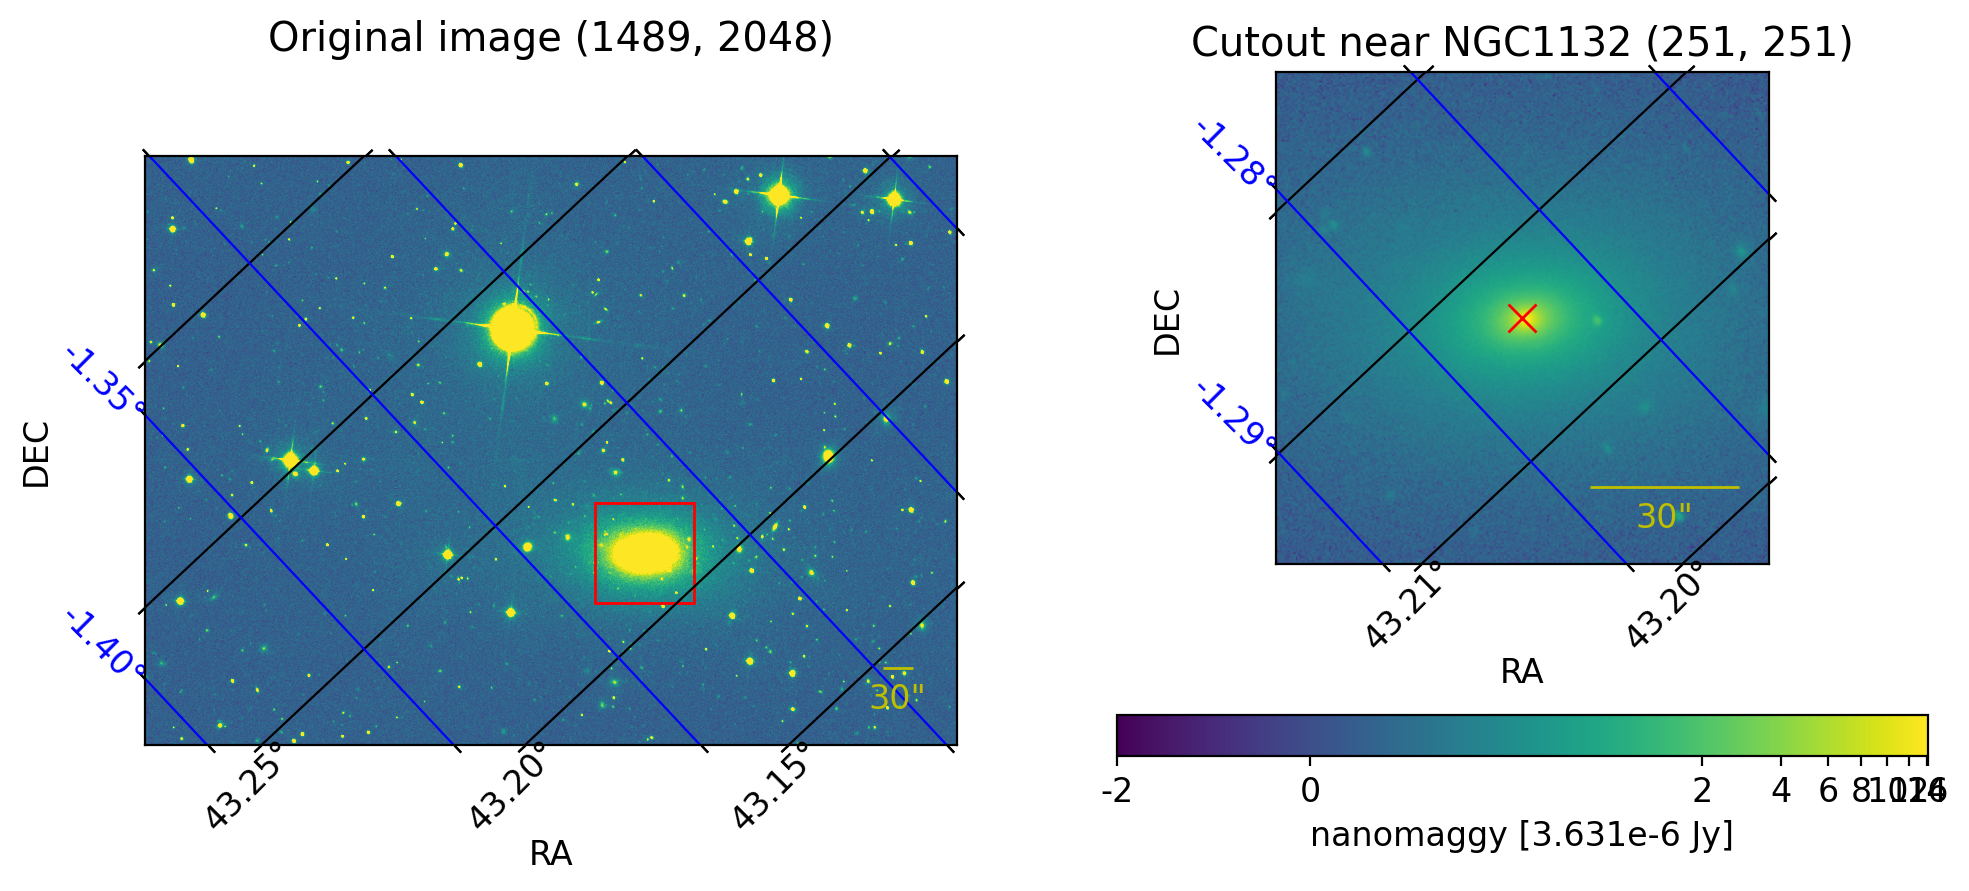

In [3]:
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot(121, projection=ccd_orig.wcs)
ax1 = plt.subplot(122, projection=cut.wcs)

vis.norm_imshow(ax0, data_orig, zscale=True)
im = vis.norm_imshow(ax1, data, stretch="log", log_a=1000)
vis.colorbaring(fig, ax1, im, fmt="%.0f", pad=0.2, label="nanomaggy [3.631e-6 Jy]")
for i, (ax, sp) in enumerate(zip([ax0, ax1], [0.05, 0.01])):
    lon, lat = ax.coords
    lon.set_axislabel("RA", minpad=0.5)
    lat.set_axislabel("DEC", minpad=0.5)
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks(spacing=sp*u.deg)  # or, e.g., number=4
    lat.set_ticks(spacing=sp*u.deg) 
    lon.set_ticklabel(color='k', rotation=45, ha='left', va="bottom", rotation_mode='anchor')
    lat.set_ticklabel(color='b', rotation=-45, ha='left', va="bottom", rotation_mode='anchor')
    lon.grid(True, color='k', ls='-')
    lat.grid(True, color='b', ls='-')
    add_scalebar(ax, length=30*u.arcsec, color='y', label='30"', corner='bottom right')
    # lon.set_ticks_position('bt')
    # lon.set_ticklabel_position('bt')
    # lon.set_axislabel_position('bt')
    # lat.set_ticks_position('lr')
    # lat.set_ticklabel_position('lr')
    # lat.set_axislabel_position('lr')

cut.plot_on_original(ax=ax0, color='r', linewidth=1)
ax1.plot(cut.center_cutout[0], cut.center_cutout[1], 'rx', ms=10)

ax0.set_title(f"Original image {ccd_orig.shape}", y=1.15)
ax1.set_title(f"Cutout near NGC1132 {cut.shape}")
plt.tight_layout()
plt.show()

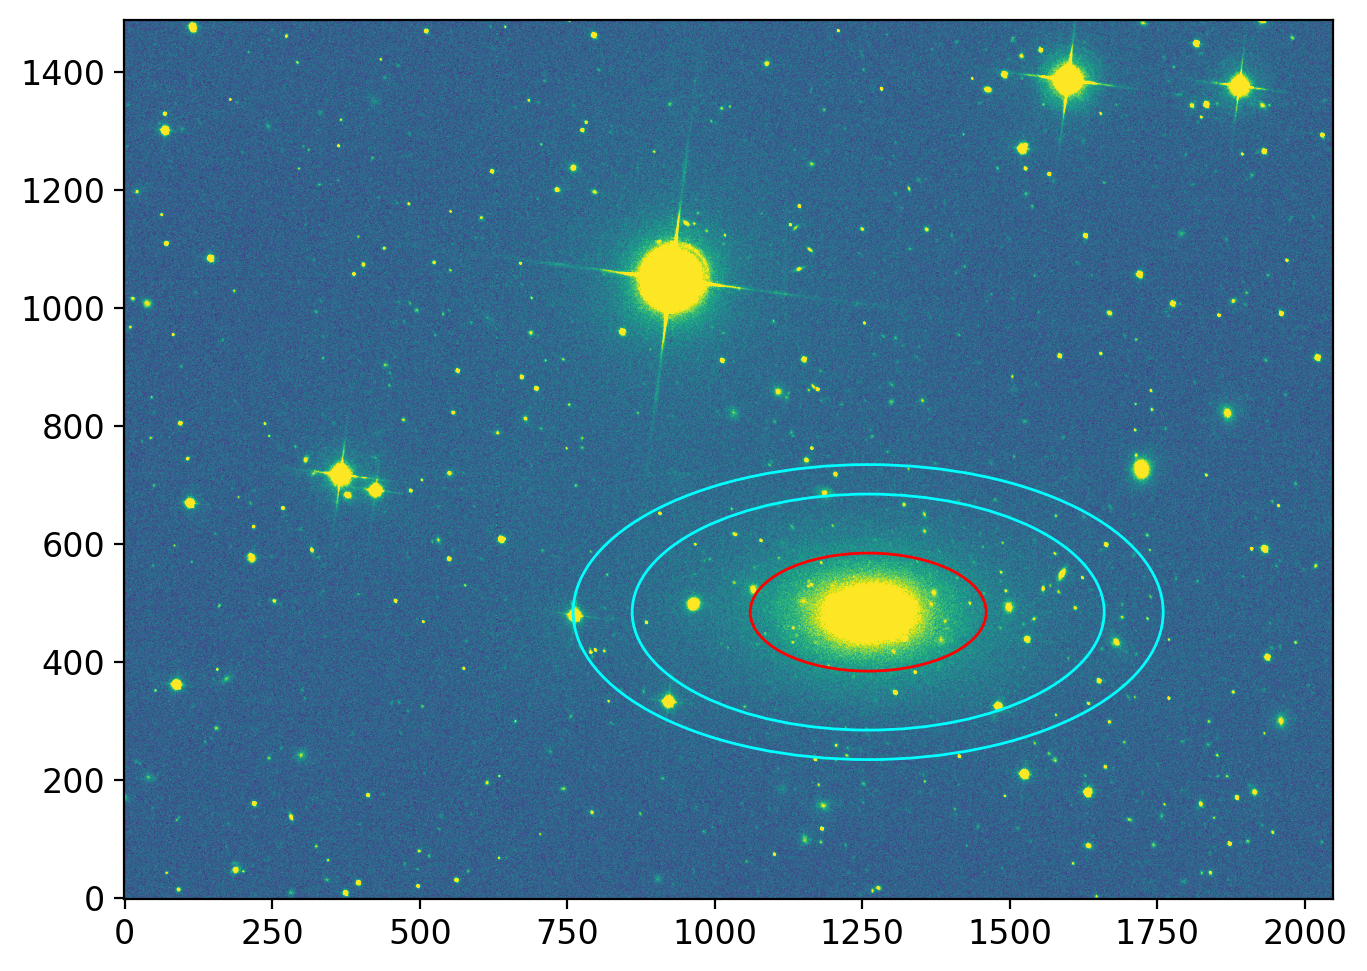

In [4]:
ap = EllipticalAperture(cut.center_original, a=200, b=100, theta=0)
an = EllipticalAnnulus(cut.center_original, a_in=ap.a*2, a_out=ap.a*2.5, b_out=ap.b*2.5)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, data_orig, zscale=True)
ap.plot(axs, color='r')
an.plot(axs, color='cyan')

plt.tight_layout()
plt.show();

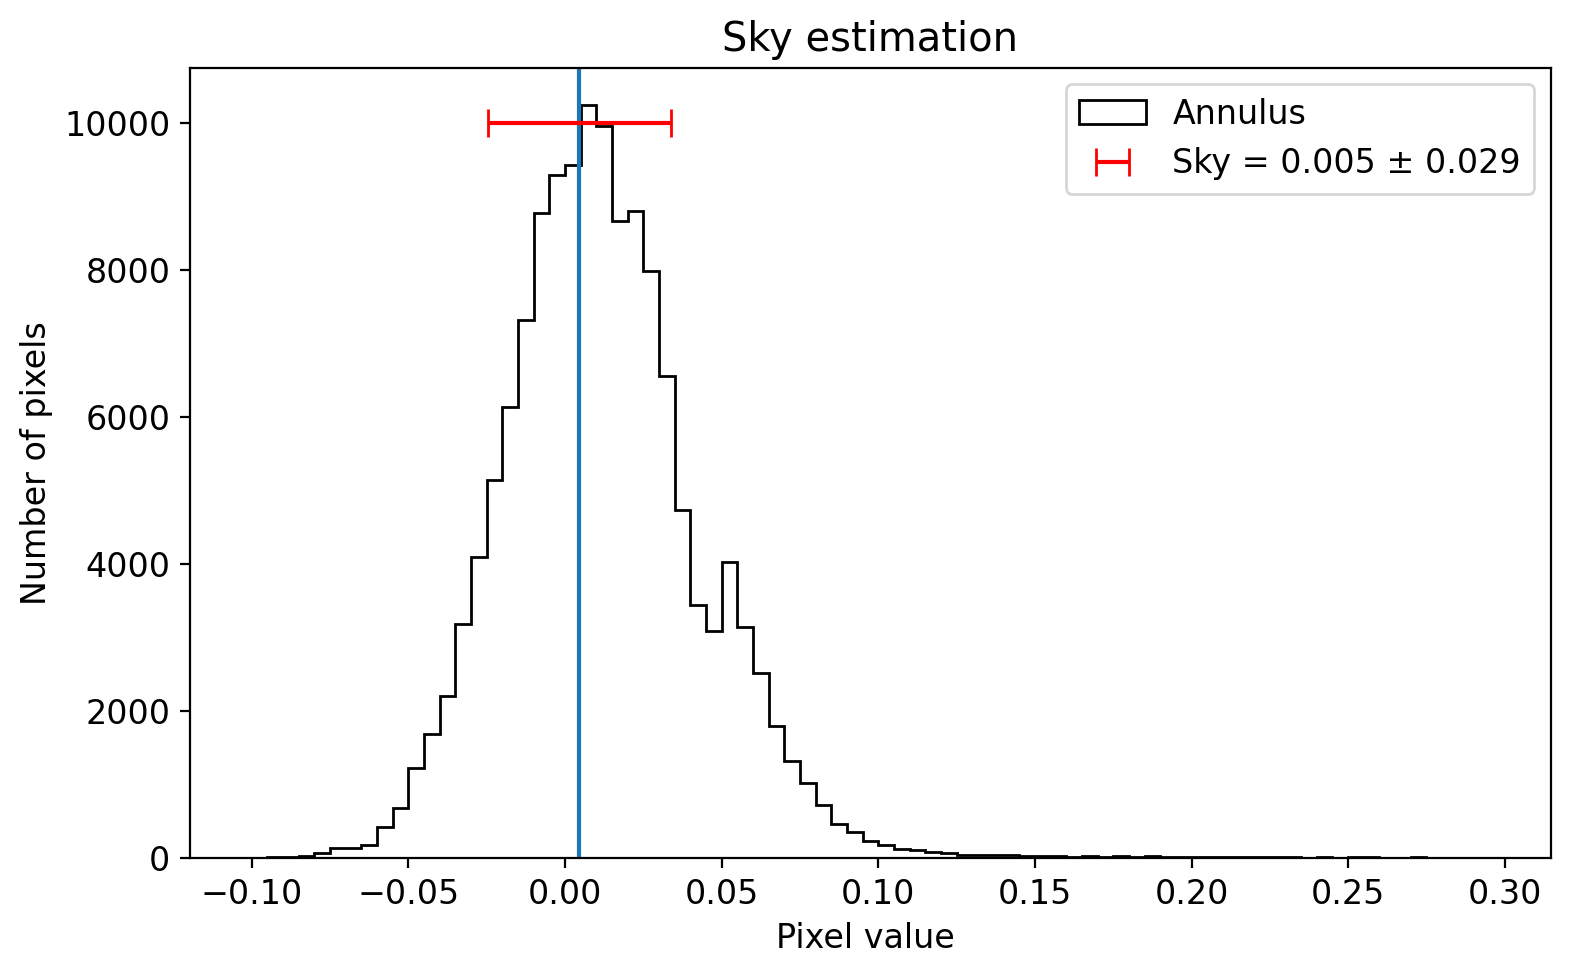

id  xcenter  ycenter  aperture_sum  aperture_sum_err      msky      ssky   
0   1   1260.0    485.0  12544.034143        112.021233  0.004562  0.029133  \

     nsky  nrej        aparea    source_sum  source_sum_err        mag   
0  139072  2284  62831.853072  12257.417864      112.259005 -10.220997  \

       merr         snr  bad  nbadpix  
0  0.009944  109.188727    0        0

In [5]:
_data = data_orig.copy()
_data[_data<0] = 0
phot = ypu.apphot_annulus(data_orig, ap, an, error=np.sqrt(_data))

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

axs.hist(an.to_mask(method='center').multiply(data_orig, fill_value=np.nan).flatten(), 
         bins=np.arange(-0.1, 0.3, 0.005), histtype='step', color='k', label='Annulus')
axs.axvline(phot["msky"][0])
axs.errorbar(phot["msky"][0], 10000, xerr=phot["ssky"][0], color='r', capsize=5, capthick=1,
             ls="", label=f"Sky = {phot['msky'][0]:.3f} ± {phot['ssky'][0]:.3f}")
axs.set(xlabel="Pixel value ", ylabel="Number of pixels", title="Sky estimation")
axs.legend()
plt.tight_layout()
plt.show();

phot

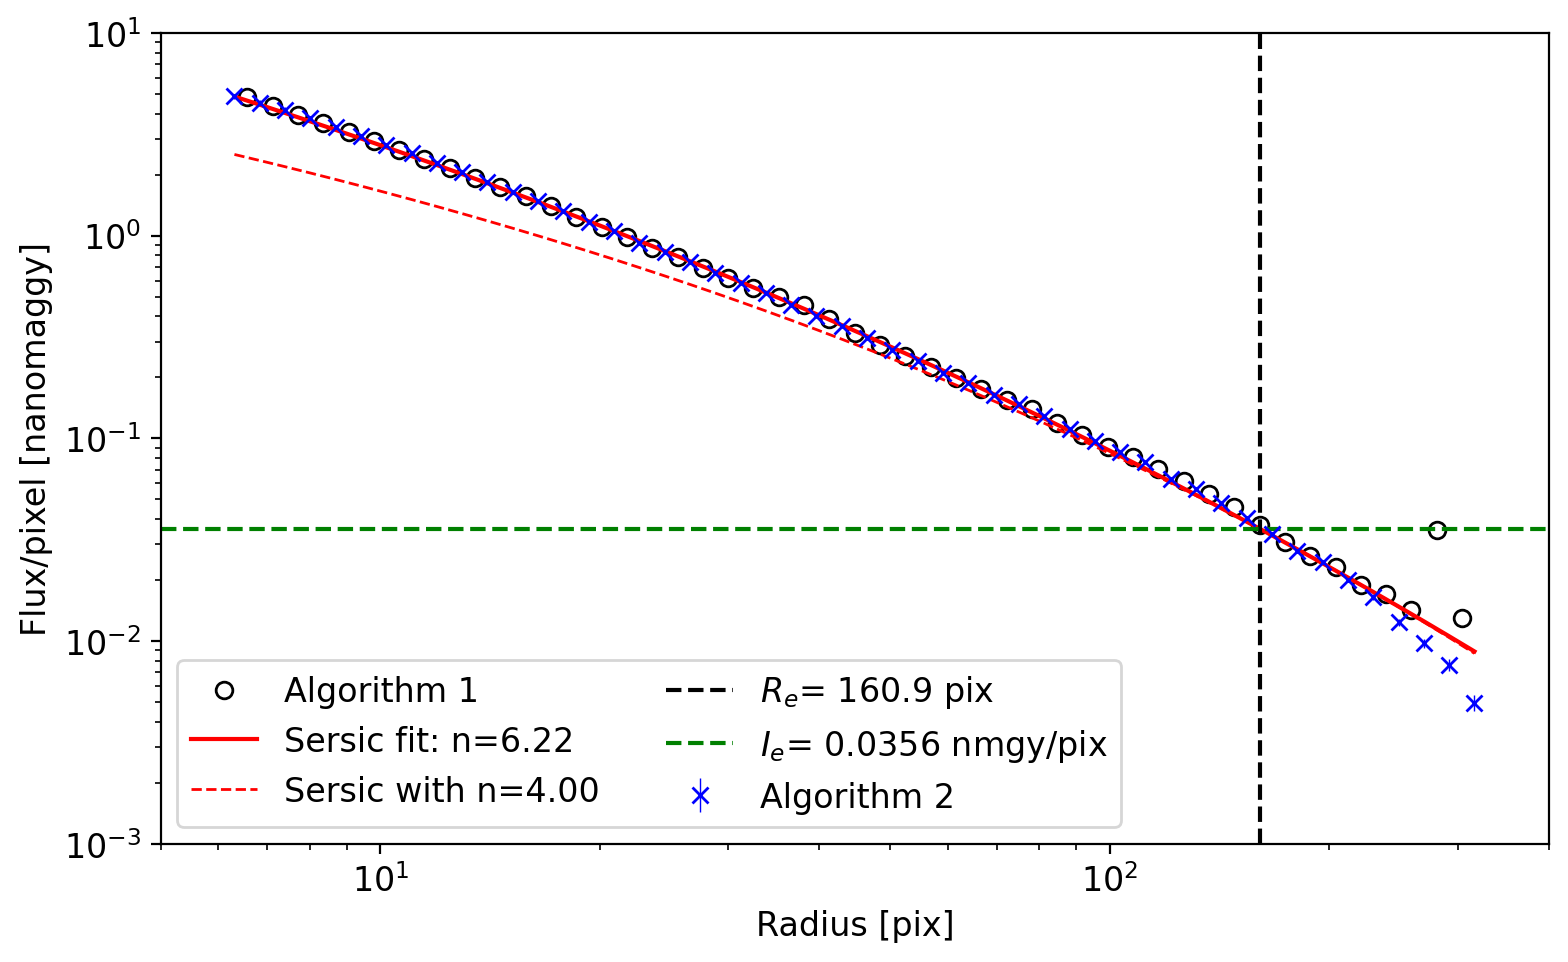

In [6]:
def sersic(r, ie=1, r_e=1, n=4):
    return ie * np.exp(-gammaincinv(2*n, 0.5) * ((r/r_e)**(1/n) - 1))


radii = np.logspace(0.8, 2.5, 50)
aps1 = [CircularAperture(cut.center_original, r) for r in radii]
phots1 = ypu.apphot_annulus(data_orig, aps1, annulus=an, error=np.sqrt(_data))
# Do the photometry using the annulus defined above

phots2 = []
phots2_err = []
for i, r in enumerate(radii):
    _an = CircularAnnulus(cut.center_original, r_in=r-1, r_out=r+1)
    _phot = ypu.sky_fit(data_orig, _an, method="mean", sigma=3, maxiters=5, to_table=False)
    phots2.append(_phot["msky"] - phot["msky"][0])
    # Subtract the sky value found above
    phots2_err.append(_phot["ssky"]/np.sqrt(_phot["nsky"]))

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

popt, _ = curve_fit(sersic, xdata=radii, ydata=phots2, sigma=phots2_err, absolute_sigma=True)
axs.plot(radii[:-1] + np.ediff1d(radii)/2,
         np.ediff1d(phots1['source_sum'])/np.ediff1d(phots1["aparea"]),
         'ko', mfc="none", label='Algorithm 1')
axs.errorbar(radii, phots2, yerr=phots2_err, color="b", elinewidth=0.5,
             marker="x", ls="", mfc="none", label='Algorithm 2')
axs.set(xscale='log', yscale="log", xlabel="Radius [pix]", ylabel="Flux/pixel [nanomaggy]",
        xlim=(5, an.a_in), ylim=(1.e-3, 1.e+1))
axs.plot(radii, sersic(radii, *popt), 'r-', label=f'Sersic fit: n={popt[2]:.2f}')
axs.plot(radii, sersic(radii, popt[0], popt[1], 4), 'r--', label=f'Sersic with n=4.00', lw=1)
axs.axvline(popt[1], color="k", ls="--", label=f"$R_e$= {popt[1]:.1f} pix")
axs.axhline(popt[0], color="g", ls="--", label=f"$I_e$= {popt[0]:.4f} nmgy/pix")
axs.legend(loc=3, ncol=2)
plt.tight_layout()
plt.show()

In [7]:
phots1dd

NameError: name 'phots1dd' is not defined

In [8]:
box_size = 50
filter_size = 9

avg, med, std = sigma_clipped_stats(data_orig, sigma=3, maxiters=5)
mask = data_orig  > med + 2*std
bkg = Background2D(data_all, mask=mask, box_size=box_size, filter_size=filter_size, exclude_percentile=5)
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

#axs[0].
# vis.norm_imshow(axs, data_all - bkg.background, zscale=True)
vis.norm_imshow(axs[0], data_all, zscale=True)
vis.norm_imshow(axs[0], mask, alpha=0.5, cmap='Reds')
im = vis.norm_imshow(axs[1], bkg.background, zscale=True)
vis.colorbaring(fig, axs[1], im, fmt="%.3f", pad=0.1, label="nanomaggy [3.631e-6 Jy]")
axs[0].set(title="Image with Mask (faint red)")
axs[1].set(title="Background estimation")
plt.tight_layout()
plt.show();


NameError: name 'data_all' is not defined

In [9]:
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5, std_ddof=1)
threshold = med + 3 * std
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)
axs[0].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(data, origin='lower', alpha=0.9)

axs[0].set_title("Segmentation of Sources")
axs[1].set_title("Overplotted with data")
plt.tight_layout()

TypeError: detect_sources() got an unexpected keyword argument 'filter_kernel'